In [ ]:
!pip install -q onnxruntime
#!pip install -q --upgrade pillow==6.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install -q albumentations==0.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 KB 2.8 MB/s eta 0:00:00


In [ ]:
!python3 -m pip install paddlepaddle
!pip install -q python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.5/385.5 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.6 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
%matplotlib inline
import cv2

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
import torch
from IPython.display import Image, clear_output
import os
os.chdir('/drive/My Drive/Colab_Notebooks')

In [ ]:
import Levenshtein

def enlarge_plt_display(image, scale_factor):
    width = int(image.shape[1] * scale_factor / 100)
    height = int(image.shape[0] * scale_factor / 100)
    dim = (width, height)
    plt.figure(figsize = dim)
    plt.axis('off') 
    plt.imshow(image)

def get_cer(list_1, list_2):
  error_chars = 0
  for i,k in zip(list_1, list_2):
    error_chars += (editdistance.eval(i, k) / len(k))
  return error_chars / eval_df.shape[0]

def lev_ratio_func(text_1, text_2):
    lev_d = Levenshtein.distance(text_1, text_2)
    lev_ratio = (len(text_1) + len(text_2) - lev_d) / (len(text_1)+len(text_2))
    return lev_ratio

def lev_perc_func(text_1, text_2):
    lev_d = Levenshtein.distance(text_1, text_2)
    max_len = max(len(text_1),len(text_2))
    lev_ratio = (max_len - lev_d) / max_len
    return lev_ratio

def get_mean_levenshtein_score(list_1, list_2):
    lev_scores = []
    for i,k in zip(list_1, list_2):
      lev_ratio = lev_perc_func(i,k)
      lev_scores.append(lev_ratio)
    mean_lev = sum(lev_scores) / len(lev_scores)
    return mean_lev

In [ ]:
os.getcwd()

'/drive/My Drive/Colab_Notebooks'

In [ ]:
all_images = os.listdir("../ocr/paddle_ocr/PaddleOCR/doc/test_images_rosim/test_images/")
all_images = natsorted(all_images)
print(len(all_images))

63


../ocr/paddle_ocr/PaddleOCR/doc/test_images_rosim/test_images/Prikaz N 197 ot 02.09.2022.pdf_0_outfile.png


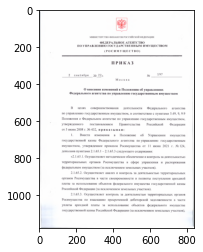

In [ ]:
image_number = 0

image = "../ocr/paddle_ocr/PaddleOCR/doc/test_images_rosim/test_images/" + all_images[image_number]

#image = 'test_images_full/' + '707106.jpg'
#image = 'images_document_text/' + all_images[2]
print(f'{image}')

opened_image = cv2.imread(image)
ori_image_rgb = cv2.cvtColor(opened_image, cv2.COLOR_BGR2RGB)

plt.imshow(ori_image_rgb)
plt.show()

In [ ]:
os.getcwd()

'/drive/My Drive/Colab_Notebooks'

In [ ]:
import onnxruntime
from onnxruntime import InferenceSession, SessionOptions

options = SessionOptions()
first_level_detection_session = InferenceSession('/drive/MyDrive/Colab_Notebooks/yolov5-rt-stack/1st_level_large_det_rosim.onnx', options, providers=["CPUExecutionProvider"])

second_level_detection_session = InferenceSession('/drive/MyDrive/Colab_Notebooks/yolov5-rt-stack/yolov5l_2st_level_rosim_own_init_weights_last.onnx', options, providers=["CPUExecutionProvider"])

In [ ]:
def correct_bb(h,w, bb_es):
    x1,y1,x2,y2 = bb_es
    if not 0 <= x1 <= w:
      x1 = 0
    if not 0 <= y1 <= h:
      y1 = 0
    if not 0 <= x2 <= w:
      x2 = w
    if not 0 <= y2 <= h:
      y2 = h
    return [x1,y1,x2,y2]

In [ ]:
from numpy.ma.core import nonzero
import regex as re
def carplate_extract(image, coordinates):
    xmin,ymin,xmax,ymax, = coordinates
    carplate_img = image[ymin:ymax + 0, xmin:xmax + 0] #xmax+20
    return carplate_img

def edit_predicted_text(list_, new_lines):

    probas = [k for i,k in list_]
    list_ = [i for i,k in list_ if k > 0.000000001]

    if new_lines == []:
        pass
    else:
        list_ = [i if k == '' else i + '\n' for i,k in zip(list_,new_lines)]

    final_text_pred = ' '.join(list_)
    #final_text_pred = re.sub(r'\s+', ' ', final_text_pred).strip()#.upper()

    final_text_pred = re.sub(r'[^\S\r\n]+', ' ', final_text_pred)

    if final_text_pred == '':
      return '', 0.99
    return final_text_pred, np.mean(probas)

def process_image_det(ori_image):
    resized_image = ori_image.astype('float32')
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    resized_image = resized_image.transpose((2, 0, 1)) / 255
    return resized_image

#new

def process_image(opened_image, detection_model = None, detection_model_type = None, sort_boxes = True):

    h, w = opened_image.shape[0:2]
    #print(h, w)
    cropped_white_images = []

    processed_image = process_image_det(opened_image)
    butched_images = np.array([processed_image])
    #results = detection_model(opened_image)

    input_feed = {"images": butched_images.astype(np.float32)}
    outputs = detection_model.run(output_names=["scores", 'labels', 'boxes'], input_feed=input_feed) #['Picture', 'Signature', 'Stamp', 'Table', 'Text', 'Title']

    if detection_model_type == 'first_level_detection_session':

      labels_predicted = outputs[1]
      filter_dict = set([0, 1, 2])
      t_f_matrix = [False if i in filter_dict else True for i in labels_predicted]

      boxes_predicted = outputs[2][t_f_matrix]
      probabilities = outputs[0][t_f_matrix]
    if detection_model_type == 'second_level_detection_session':
      boxes_predicted = outputs[2]
      probabilities = outputs[0]

    #boxes_predicted = results.xyxy[0].tolist()
    if len(boxes_predicted) == 0:
        return [], [], []

    #correct BB'es
    boxes_predicted = [correct_bb(h, w, i) for i in boxes_predicted]

    new_lines = []
    
    if sort_boxes:
    
      n_iter = 0
      while len(boxes_predicted) > 0:

          argmin_y = np.argmin(np.array(boxes_predicted)[:, 1])
          min_y_box = np.array(boxes_predicted)[argmin_y,: ]
          lower_y_boundary_min_box = min_y_box[1]
          upper_y_boundary_min_box = min_y_box[3]

          indexes_to_sort = []
          for i in range(len(boxes_predicted)):
              y1, y2 = lower_y_boundary_min_box, upper_y_boundary_min_box
              y1_compare, y2_compare = boxes_predicted[i][1], boxes_predicted[i][3]
              intersection_on_y_axis = min([y2, y2_compare]) - max([y1, y1_compare])

              inter_threshold_1 = upper_y_boundary_min_box - lower_y_boundary_min_box
              inter_threshold_2 = y2_compare - y1_compare

              #inter_threshold = np.min([inter_threshold_1, inter_threshold_2]) * 0.2
              inter_threshold = np.min([inter_threshold_1, inter_threshold_2]) * 0.5

              if intersection_on_y_axis > inter_threshold:
                indexes_to_sort.append(i)
                new_lines.append('')
              #print(intersection_on_y_axis)

          #new_lines.append('\n')
          new_lines[-1] = '\n'
              
          if n_iter == 0:
            a = np.array(boxes_predicted)[indexes_to_sort]
            a = a[a[:, 0].argsort()]

          else:
            a_2 = np.array(boxes_predicted)[indexes_to_sort]
            a_2 = a_2[a_2[:, 0].argsort()]
            a = np.concatenate((a,a_2), axis=0)

          boxes_predicted = np.delete(boxes_predicted, indexes_to_sort, axis=0)

          #print(len(boxes_predicted))

          n_iter += 1

      boxes_predicted = a.tolist()


    for item in boxes_predicted:
        coordinates = int(item[0]), int(item[1]), int(item[2]), int(item[3])
        croped = carplate_extract(opened_image, coordinates)

        cropped_white_images.append(croped)
    return cropped_white_images, probabilities, new_lines


def predict_full_image(image_, detection_model = None, detection_model_type = None, sort_boxes = True):

    image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)

    croped, probabilities, new_lines = process_image(image_, detection_model = detection_model, detection_model_type = detection_model_type, sort_boxes = sort_boxes)

    if len(croped) == 0:
        croped = np.array([image_])

    text_preds, _ = text_recognizer(croped)

    predicted_texts = [i[0] for i in text_preds]
    predicted_probas = [i[1] for i in text_preds]

    final_pred, proba_ = edit_predicted_text(list(zip(predicted_texts,predicted_probas)), new_lines)
    #final_pred, proba_ = edit_predicted_text(predicted_texts)

    return final_pred, proba_

In [ ]:
#Код для заргузки модели SVTR-T

os.chdir('/drive/My Drive/ocr/paddle_ocr/PaddleOCR')
!python3 -m pip install paddlepaddle
!pip3 install -r requirements.txt
!pip install "paddleocr>=2.0.1"

import sys
sys.path.append('/drive/MyDrive')

import os
import sys
from PIL import Image
__dir__ = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(__dir__)
sys.path.insert(0, os.path.abspath(os.path.join(__dir__, '../..')))

import os
os.chdir('/drive/My Drive/ocr/paddle_ocr/PaddleOCR')

os.environ["FLAGS_allocator_strategy"] = 'auto_growth'

import cv2
import numpy as np
import math
import time
import traceback
import paddle

import tools.infer.utility as utility
from ppocr.postprocess import build_post_process
from ppocr.utils.logging import get_logger
from ppocr.utils.utility import get_image_file_list, check_and_read

logger = get_logger()

import argparse

class TextRecognizer(object):
    def __init__(self, args):
        self.rec_image_shape = [int(v) for v in args.rec_image_shape.split(",")]
        self.rec_batch_num = args.rec_batch_num
        self.rec_algorithm = args.rec_algorithm
        postprocess_params = {
            'name': 'CTCLabelDecode',
            "character_dict_path": args.rec_char_dict_path,
            "use_space_char": args.use_space_char
        }
        if self.rec_algorithm == "SRN":
            postprocess_params = {
                'name': 'SRNLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == "RARE":
            postprocess_params = {
                'name': 'AttnLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == 'NRTR':
            postprocess_params = {
                'name': 'NRTRLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == "SAR":
            postprocess_params = {
                'name': 'SARLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == "VisionLAN":
            postprocess_params = {
                'name': 'VLLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == 'ViTSTR':
            postprocess_params = {
                'name': 'ViTSTRLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == 'ABINet':
            postprocess_params = {
                'name': 'ABINetLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == "SPIN":
            postprocess_params = {
                'name': 'SPINLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == "RobustScanner":
            postprocess_params = {
                'name': 'SARLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char,
                "rm_symbol": True
            }
        elif self.rec_algorithm == 'RFL':
            postprocess_params = {
                'name': 'RFLLabelDecode',
                "character_dict_path": None,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == "PREN":
            postprocess_params = {'name': 'PRENLabelDecode'}
        elif self.rec_algorithm == "CAN":
            self.inverse = args.rec_image_inverse
            postprocess_params = {
                'name': 'CANLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        self.postprocess_op = build_post_process(postprocess_params)
        self.predictor, self.input_tensor, self.output_tensors, self.config = \
            utility.create_predictor(args, 'rec', logger)
        self.benchmark = args.benchmark
        self.use_onnx = args.use_onnx
        if args.benchmark:
            import auto_log
            pid = os.getpid()
            gpu_id = utility.get_infer_gpuid()
            self.autolog = auto_log.AutoLogger(
                model_name="rec",
                model_precision=args.precision,
                batch_size=args.rec_batch_num,
                data_shape="dynamic",
                save_path=None,  #args.save_log_path,
                inference_config=self.config,
                pids=pid,
                process_name=None,
                gpu_ids=gpu_id if args.use_gpu else None,
                time_keys=[
                    'preprocess_time', 'inference_time', 'postprocess_time'
                ],
                warmup=0,
                logger=logger)

    def resize_norm_img(self, img, max_wh_ratio):
        imgC, imgH, imgW = self.rec_image_shape
        if self.rec_algorithm == 'NRTR' or self.rec_algorithm == 'ViTSTR':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # return padding_im
            image_pil = Image.fromarray(np.uint8(img))
            if self.rec_algorithm == 'ViTSTR':
                img = image_pil.resize([imgW, imgH], Image.BICUBIC)
            else:
                img = image_pil.resize([imgW, imgH], Image.ANTIALIAS)
            img = np.array(img)
            norm_img = np.expand_dims(img, -1)
            norm_img = norm_img.transpose((2, 0, 1))
            if self.rec_algorithm == 'ViTSTR':
                norm_img = norm_img.astype(np.float32) / 255.
            else:
                norm_img = norm_img.astype(np.float32) / 128. - 1.
            return norm_img
        elif self.rec_algorithm == 'RFL':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_image = cv2.resize(
                img, (imgW, imgH), interpolation=cv2.INTER_CUBIC)
            resized_image = resized_image.astype('float32')
            resized_image = resized_image / 255
            resized_image = resized_image[np.newaxis, :]
            resized_image -= 0.5
            resized_image /= 0.5
            return resized_image

        assert imgC == img.shape[2]
        imgW = int((imgH * max_wh_ratio))
        if self.use_onnx:
            w = self.input_tensor.shape[3:][0]
            if w is not None and w > 0:
                imgW = w

        h, w = img.shape[:2]
        ratio = w / float(h)
        if math.ceil(imgH * ratio) > imgW:
            resized_w = imgW
        else:
            resized_w = int(math.ceil(imgH * ratio))
        if self.rec_algorithm == 'RARE':
            if resized_w > self.rec_image_shape[2]:
                resized_w = self.rec_image_shape[2]
            imgW = self.rec_image_shape[2]
        resized_image = cv2.resize(img, (resized_w, imgH))
        resized_image = resized_image.astype('float32')
        resized_image = resized_image.transpose((2, 0, 1)) / 255
        resized_image -= 0.5
        resized_image /= 0.5
        padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
        padding_im[:, :, 0:resized_w] = resized_image
        return padding_im

    def resize_norm_img_vl(self, img, image_shape):

        imgC, imgH, imgW = image_shape
        img = img[:, :, ::-1]  # bgr2rgb
        resized_image = cv2.resize(
            img, (imgW, imgH), interpolation=cv2.INTER_LINEAR)
        resized_image = resized_image.astype('float32')
        resized_image = resized_image.transpose((2, 0, 1)) / 255
        return resized_image

    def resize_norm_img_srn(self, img, image_shape):
        imgC, imgH, imgW = image_shape

        img_black = np.zeros((imgH, imgW))
        im_hei = img.shape[0]
        im_wid = img.shape[1]

        if im_wid <= im_hei * 1:
            img_new = cv2.resize(img, (imgH * 1, imgH))
        elif im_wid <= im_hei * 2:
            img_new = cv2.resize(img, (imgH * 2, imgH))
        elif im_wid <= im_hei * 3:
            img_new = cv2.resize(img, (imgH * 3, imgH))
        else:
            img_new = cv2.resize(img, (imgW, imgH))

        img_np = np.asarray(img_new)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
        img_black[:, 0:img_np.shape[1]] = img_np
        img_black = img_black[:, :, np.newaxis]

        row, col, c = img_black.shape
        c = 1

        return np.reshape(img_black, (c, row, col)).astype(np.float32)

    def srn_other_inputs(self, image_shape, num_heads, max_text_length):

        imgC, imgH, imgW = image_shape
        feature_dim = int((imgH / 8) * (imgW / 8))

        encoder_word_pos = np.array(range(0, feature_dim)).reshape(
            (feature_dim, 1)).astype('int64')
        gsrm_word_pos = np.array(range(0, max_text_length)).reshape(
            (max_text_length, 1)).astype('int64')

        gsrm_attn_bias_data = np.ones((1, max_text_length, max_text_length))
        gsrm_slf_attn_bias1 = np.triu(gsrm_attn_bias_data, 1).reshape(
            [-1, 1, max_text_length, max_text_length])
        gsrm_slf_attn_bias1 = np.tile(
            gsrm_slf_attn_bias1,
            [1, num_heads, 1, 1]).astype('float32') * [-1e9]

        gsrm_slf_attn_bias2 = np.tril(gsrm_attn_bias_data, -1).reshape(
            [-1, 1, max_text_length, max_text_length])
        gsrm_slf_attn_bias2 = np.tile(
            gsrm_slf_attn_bias2,
            [1, num_heads, 1, 1]).astype('float32') * [-1e9]

        encoder_word_pos = encoder_word_pos[np.newaxis, :]
        gsrm_word_pos = gsrm_word_pos[np.newaxis, :]

        return [
            encoder_word_pos, gsrm_word_pos, gsrm_slf_attn_bias1,
            gsrm_slf_attn_bias2
        ]

    def process_image_srn(self, img, image_shape, num_heads, max_text_length):
        norm_img = self.resize_norm_img_srn(img, image_shape)
        norm_img = norm_img[np.newaxis, :]

        [encoder_word_pos, gsrm_word_pos, gsrm_slf_attn_bias1, gsrm_slf_attn_bias2] = \
            self.srn_other_inputs(image_shape, num_heads, max_text_length)

        gsrm_slf_attn_bias1 = gsrm_slf_attn_bias1.astype(np.float32)
        gsrm_slf_attn_bias2 = gsrm_slf_attn_bias2.astype(np.float32)
        encoder_word_pos = encoder_word_pos.astype(np.int64)
        gsrm_word_pos = gsrm_word_pos.astype(np.int64)

        return (norm_img, encoder_word_pos, gsrm_word_pos, gsrm_slf_attn_bias1,
                gsrm_slf_attn_bias2)

    def resize_norm_img_sar(self, img, image_shape,
                            width_downsample_ratio=0.25):
        imgC, imgH, imgW_min, imgW_max = image_shape
        h = img.shape[0]
        w = img.shape[1]
        valid_ratio = 1.0
        # make sure new_width is an integral multiple of width_divisor.
        width_divisor = int(1 / width_downsample_ratio)
        # resize
        ratio = w / float(h)
        resize_w = math.ceil(imgH * ratio)
        if resize_w % width_divisor != 0:
            resize_w = round(resize_w / width_divisor) * width_divisor
        if imgW_min is not None:
            resize_w = max(imgW_min, resize_w)
        if imgW_max is not None:
            valid_ratio = min(1.0, 1.0 * resize_w / imgW_max)
            resize_w = min(imgW_max, resize_w)
        resized_image = cv2.resize(img, (resize_w, imgH))
        resized_image = resized_image.astype('float32')
        # norm 
        if image_shape[0] == 1:
            resized_image = resized_image / 255
            resized_image = resized_image[np.newaxis, :]
        else:
            resized_image = resized_image.transpose((2, 0, 1)) / 255
        resized_image -= 0.5
        resized_image /= 0.5
        resize_shape = resized_image.shape
        padding_im = -1.0 * np.ones((imgC, imgH, imgW_max), dtype=np.float32)
        padding_im[:, :, 0:resize_w] = resized_image
        pad_shape = padding_im.shape

        return padding_im, resize_shape, pad_shape, valid_ratio

    def resize_norm_img_spin(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # return padding_im
        img = cv2.resize(img, tuple([100, 32]), cv2.INTER_CUBIC)
        img = np.array(img, np.float32)
        img = np.expand_dims(img, -1)
        img = img.transpose((2, 0, 1))
        mean = [127.5]
        std = [127.5]
        mean = np.array(mean, dtype=np.float32)
        std = np.array(std, dtype=np.float32)
        mean = np.float32(mean.reshape(1, -1))
        stdinv = 1 / np.float32(std.reshape(1, -1))
        img -= mean
        img *= stdinv
        return img

    def resize_norm_img_svtr(self, img, image_shape):

        imgC, imgH, imgW = image_shape
        resized_image = cv2.resize(
            img, (imgW, imgH), interpolation=cv2.INTER_LINEAR)
        resized_image = resized_image.astype('float32')
        resized_image = resized_image.transpose((2, 0, 1)) / 255
        resized_image -= 0.5
        resized_image /= 0.5
        return resized_image

    def resize_norm_img_abinet(self, img, image_shape):

        imgC, imgH, imgW = image_shape

        resized_image = cv2.resize(
            img, (imgW, imgH), interpolation=cv2.INTER_LINEAR)
        resized_image = resized_image.astype('float32')
        resized_image = resized_image / 255.

        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        resized_image = (
            resized_image - mean[None, None, ...]) / std[None, None, ...]
        resized_image = resized_image.transpose((2, 0, 1))
        resized_image = resized_image.astype('float32')

        return resized_image

    def norm_img_can(self, img, image_shape):

        img = cv2.cvtColor(
            img, cv2.COLOR_BGR2GRAY)  # CAN only predict gray scale image

        if self.inverse:
            img = 255 - img

        if self.rec_image_shape[0] == 1:
            h, w = img.shape
            _, imgH, imgW = self.rec_image_shape
            if h < imgH or w < imgW:
                padding_h = max(imgH - h, 0)
                padding_w = max(imgW - w, 0)
                img_padded = np.pad(img, ((0, padding_h), (0, padding_w)),
                                    'constant',
                                    constant_values=(255))
                img = img_padded

        img = np.expand_dims(img, 0) / 255.0  # h,w,c -> c,h,w
        img = img.astype('float32')

        return img

    def __call__(self, img_list):
        img_num = len(img_list)
        # Calculate the aspect ratio of all text bars
        width_list = []
        for img in img_list:
            width_list.append(img.shape[1] / float(img.shape[0]))
        # Sorting can speed up the recognition process
        indices = np.argsort(np.array(width_list))
        rec_res = [['', 0.0]] * img_num
        batch_num = self.rec_batch_num
        st = time.time()
        if self.benchmark:
            self.autolog.times.start()
        for beg_img_no in range(0, img_num, batch_num):
            end_img_no = min(img_num, beg_img_no + batch_num)
            norm_img_batch = []
            if self.rec_algorithm == "SRN":
                encoder_word_pos_list = []
                gsrm_word_pos_list = []
                gsrm_slf_attn_bias1_list = []
                gsrm_slf_attn_bias2_list = []
            if self.rec_algorithm == "SAR":
                valid_ratios = []
            imgC, imgH, imgW = self.rec_image_shape[:3]
            max_wh_ratio = imgW / imgH
            # max_wh_ratio = 0
            for ino in range(beg_img_no, end_img_no):
                h, w = img_list[indices[ino]].shape[0:2]
                wh_ratio = w * 1.0 / h
                max_wh_ratio = max(max_wh_ratio, wh_ratio)
            for ino in range(beg_img_no, end_img_no):
                if self.rec_algorithm == "SAR":
                    norm_img, _, _, valid_ratio = self.resize_norm_img_sar(
                        img_list[indices[ino]], self.rec_image_shape)
                    norm_img = norm_img[np.newaxis, :]
                    valid_ratio = np.expand_dims(valid_ratio, axis=0)
                    valid_ratios.append(valid_ratio)
                    norm_img_batch.append(norm_img)
                elif self.rec_algorithm == "SRN":
                    norm_img = self.process_image_srn(
                        img_list[indices[ino]], self.rec_image_shape, 8, 25)
                    encoder_word_pos_list.append(norm_img[1])
                    gsrm_word_pos_list.append(norm_img[2])
                    gsrm_slf_attn_bias1_list.append(norm_img[3])
                    gsrm_slf_attn_bias2_list.append(norm_img[4])
                    norm_img_batch.append(norm_img[0])
                elif self.rec_algorithm == "SVTR":
                    norm_img = self.resize_norm_img_svtr(img_list[indices[ino]],
                                                         self.rec_image_shape)
                    norm_img = norm_img[np.newaxis, :]
                    norm_img_batch.append(norm_img)
                elif self.rec_algorithm in ["VisionLAN", "PREN"]:
                    norm_img = self.resize_norm_img_vl(img_list[indices[ino]],
                                                       self.rec_image_shape)
                    norm_img = norm_img[np.newaxis, :]
                    norm_img_batch.append(norm_img)
                elif self.rec_algorithm == 'SPIN':
                    norm_img = self.resize_norm_img_spin(img_list[indices[ino]])
                    norm_img = norm_img[np.newaxis, :]
                    norm_img_batch.append(norm_img)
                elif self.rec_algorithm == "ABINet":
                    norm_img = self.resize_norm_img_abinet(
                        img_list[indices[ino]], self.rec_image_shape)
                    norm_img = norm_img[np.newaxis, :]
                    norm_img_batch.append(norm_img)
                elif self.rec_algorithm == "RobustScanner":
                    norm_img, _, _, valid_ratio = self.resize_norm_img_sar(
                        img_list[indices[ino]],
                        self.rec_image_shape,
                        width_downsample_ratio=0.25)
                    norm_img = norm_img[np.newaxis, :]
                    valid_ratio = np.expand_dims(valid_ratio, axis=0)
                    valid_ratios = []
                    valid_ratios.append(valid_ratio)
                    norm_img_batch.append(norm_img)
                    word_positions_list = []
                    word_positions = np.array(range(0, 40)).astype('int64')
                    word_positions = np.expand_dims(word_positions, axis=0)
                    word_positions_list.append(word_positions)
                elif self.rec_algorithm == "CAN":
                    norm_img = self.norm_img_can(img_list[indices[ino]],
                                                 max_wh_ratio)
                    norm_img = norm_img[np.newaxis, :]
                    norm_img_batch.append(norm_img)
                    norm_image_mask = np.ones(norm_img.shape, dtype='float32')
                    word_label = np.ones([1, 36], dtype='int64')
                    norm_img_mask_batch = []
                    word_label_list = []
                    norm_img_mask_batch.append(norm_image_mask)
                    word_label_list.append(word_label)
                else:
                    norm_img = self.resize_norm_img(img_list[indices[ino]],
                                                    max_wh_ratio)
                    norm_img = norm_img[np.newaxis, :]
                    norm_img_batch.append(norm_img)
            norm_img_batch = np.concatenate(norm_img_batch)
            norm_img_batch = norm_img_batch.copy()
            if self.benchmark:
                self.autolog.times.stamp()

            if self.rec_algorithm == "SRN":
                encoder_word_pos_list = np.concatenate(encoder_word_pos_list)
                gsrm_word_pos_list = np.concatenate(gsrm_word_pos_list)
                gsrm_slf_attn_bias1_list = np.concatenate(
                    gsrm_slf_attn_bias1_list)
                gsrm_slf_attn_bias2_list = np.concatenate(
                    gsrm_slf_attn_bias2_list)

                inputs = [
                    norm_img_batch,
                    encoder_word_pos_list,
                    gsrm_word_pos_list,
                    gsrm_slf_attn_bias1_list,
                    gsrm_slf_attn_bias2_list,
                ]
                if self.use_onnx:
                    input_dict = {}
                    input_dict[self.input_tensor.name] = norm_img_batch
                    outputs = self.predictor.run(self.output_tensors,
                                                 input_dict)
                    preds = {"predict": outputs[2]}
                else:
                    input_names = self.predictor.get_input_names()
                    for i in range(len(input_names)):
                        input_tensor = self.predictor.get_input_handle(
                            input_names[i])
                        input_tensor.copy_from_cpu(inputs[i])
                    self.predictor.run()
                    outputs = []
                    for output_tensor in self.output_tensors:
                        output = output_tensor.copy_to_cpu()
                        outputs.append(output)
                    if self.benchmark:
                        self.autolog.times.stamp()
                    preds = {"predict": outputs[2]}
            elif self.rec_algorithm == "SAR":
                valid_ratios = np.concatenate(valid_ratios)
                inputs = [
                    norm_img_batch,
                    np.array(
                        [valid_ratios], dtype=np.float32),
                ]
                if self.use_onnx:
                    input_dict = {}
                    input_dict[self.input_tensor.name] = norm_img_batch
                    outputs = self.predictor.run(self.output_tensors,
                                                 input_dict)
                    preds = outputs[0]
                else:
                    input_names = self.predictor.get_input_names()
                    for i in range(len(input_names)):
                        input_tensor = self.predictor.get_input_handle(
                            input_names[i])
                        input_tensor.copy_from_cpu(inputs[i])
                    self.predictor.run()
                    outputs = []
                    for output_tensor in self.output_tensors:
                        output = output_tensor.copy_to_cpu()
                        outputs.append(output)
                    if self.benchmark:
                        self.autolog.times.stamp()
                    preds = outputs[0]
            elif self.rec_algorithm == "RobustScanner":
                valid_ratios = np.concatenate(valid_ratios)
                word_positions_list = np.concatenate(word_positions_list)
                inputs = [norm_img_batch, valid_ratios, word_positions_list]

                if self.use_onnx:
                    input_dict = {}
                    input_dict[self.input_tensor.name] = norm_img_batch
                    outputs = self.predictor.run(self.output_tensors,
                                                 input_dict)
                    preds = outputs[0]
                else:
                    input_names = self.predictor.get_input_names()
                    for i in range(len(input_names)):
                        input_tensor = self.predictor.get_input_handle(
                            input_names[i])
                        input_tensor.copy_from_cpu(inputs[i])
                    self.predictor.run()
                    outputs = []
                    for output_tensor in self.output_tensors:
                        output = output_tensor.copy_to_cpu()
                        outputs.append(output)
                    if self.benchmark:
                        self.autolog.times.stamp()
                    preds = outputs[0]
            elif self.rec_algorithm == "CAN":
                norm_img_mask_batch = np.concatenate(norm_img_mask_batch)
                word_label_list = np.concatenate(word_label_list)
                inputs = [norm_img_batch, norm_img_mask_batch, word_label_list]
                if self.use_onnx:
                    input_dict = {}
                    input_dict[self.input_tensor.name] = norm_img_batch
                    outputs = self.predictor.run(self.output_tensors,
                                                 input_dict)
                    preds = outputs
                else:
                    input_names = self.predictor.get_input_names()
                    input_tensor = []
                    for i in range(len(input_names)):
                        input_tensor_i = self.predictor.get_input_handle(
                            input_names[i])
                        input_tensor_i.copy_from_cpu(inputs[i])
                        input_tensor.append(input_tensor_i)
                    self.input_tensor = input_tensor
                    self.predictor.run()
                    outputs = []
                    for output_tensor in self.output_tensors:
                        output = output_tensor.copy_to_cpu()
                        outputs.append(output)
                    if self.benchmark:
                        self.autolog.times.stamp()
                    preds = outputs
            else:
                if self.use_onnx:
                    input_dict = {}
                    input_dict[self.input_tensor.name] = norm_img_batch
                    outputs = self.predictor.run(self.output_tensors,
                                                 input_dict)
                    preds = outputs[0]
                else:
                    self.input_tensor.copy_from_cpu(norm_img_batch)
                    self.predictor.run()
                    outputs = []
                    for output_tensor in self.output_tensors:
                        output = output_tensor.copy_to_cpu()
                        outputs.append(output)
                    if self.benchmark:
                        self.autolog.times.stamp()
                    if len(outputs) != 1:
                        preds = outputs
                    else:
                        preds = outputs[0]
            rec_result = self.postprocess_op(preds)
            for rno in range(len(rec_result)):
                rec_res[indices[beg_img_no + rno]] = rec_result[rno]
            if self.benchmark:
                self.autolog.times.end(stamp=True)
        return rec_res, time.time() - st



def str2bool(v):
    return v.lower() in ("true", "t", "1")

parser = argparse.ArgumentParser()
# params for prediction engine
parser.add_argument("--use_gpu", type=str2bool, default=False)
parser.add_argument("--use_xpu", type=str2bool, default=False)
parser.add_argument("--use_npu", type=str2bool, default=False)
parser.add_argument("--ir_optim", type=str2bool, default=True)
parser.add_argument("--use_tensorrt", type=str2bool, default=False)
parser.add_argument("--min_subgraph_size", type=int, default=15)
parser.add_argument("--precision", type=str, default="fp32")
parser.add_argument("--gpu_mem", type=int, default=500)

# params for text detector
parser.add_argument("--image_dir", type=str)
parser.add_argument("--page_num", type=int, default=0)
parser.add_argument("--det_algorithm", type=str, default='DB')
parser.add_argument("--det_model_dir", type=str)
parser.add_argument("--det_limit_side_len", type=float, default=960)
parser.add_argument("--det_limit_type", type=str, default='max')
parser.add_argument("--det_box_type", type=str, default='quad')

# DB parmas
parser.add_argument("--det_db_thresh", type=float, default=0.3)
parser.add_argument("--det_db_box_thresh", type=float, default=0.6)
parser.add_argument("--det_db_unclip_ratio", type=float, default=1.5)
parser.add_argument("--max_batch_size", type=int, default=10)
parser.add_argument("--use_dilation", type=str2bool, default=False)
parser.add_argument("--det_db_score_mode", type=str, default="fast")

# EAST parmas
parser.add_argument("--det_east_score_thresh", type=float, default=0.8)
parser.add_argument("--det_east_cover_thresh", type=float, default=0.1)
parser.add_argument("--det_east_nms_thresh", type=float, default=0.2)

# SAST parmas
parser.add_argument("--det_sast_score_thresh", type=float, default=0.5)
parser.add_argument("--det_sast_nms_thresh", type=float, default=0.2)

# PSE parmas
parser.add_argument("--det_pse_thresh", type=float, default=0)
parser.add_argument("--det_pse_box_thresh", type=float, default=0.85)
parser.add_argument("--det_pse_min_area", type=float, default=16)
parser.add_argument("--det_pse_scale", type=int, default=1)

# FCE parmas
parser.add_argument("--scales", type=list, default=[8, 16, 32])
parser.add_argument("--alpha", type=float, default=1.0)
parser.add_argument("--beta", type=float, default=1.0)
parser.add_argument("--fourier_degree", type=int, default=5)

# params for text recognizer
parser.add_argument("--rec_algorithm", type=str, default='SVTR_LCNet')
parser.add_argument("--rec_model_dir", type=str)
parser.add_argument("--rec_image_inverse", type=str2bool, default=True)
parser.add_argument("--rec_image_shape", type=str, default="3, 48, 320")
parser.add_argument("--rec_batch_num", type=int, default=6)
parser.add_argument("--max_text_length", type=int, default=25)
parser.add_argument(
    "--rec_char_dict_path",
    type=str,
    default="./ppocr/utils/ppocr_keys_v1.txt")
parser.add_argument("--use_space_char", type=str2bool, default=True)
parser.add_argument(
    "--vis_font_path", type=str, default="./doc/fonts/simfang.ttf")
parser.add_argument("--drop_score", type=float, default=0.5)

# params for e2e
parser.add_argument("--e2e_algorithm", type=str, default='PGNet')
parser.add_argument("--e2e_model_dir", type=str)
parser.add_argument("--e2e_limit_side_len", type=float, default=768)
parser.add_argument("--e2e_limit_type", type=str, default='max')

# PGNet parmas
parser.add_argument("--e2e_pgnet_score_thresh", type=float, default=0.5)
parser.add_argument(
    "--e2e_char_dict_path", type=str, default="./ppocr/utils/ic15_dict.txt")
parser.add_argument("--e2e_pgnet_valid_set", type=str, default='totaltext')
parser.add_argument("--e2e_pgnet_mode", type=str, default='fast')

# params for text classifier
parser.add_argument("--use_angle_cls", type=str2bool, default=False)
parser.add_argument("--cls_model_dir", type=str)
parser.add_argument("--cls_image_shape", type=str, default="3, 48, 192")
parser.add_argument("--label_list", type=list, default=['0', '180'])
parser.add_argument("--cls_batch_num", type=int, default=6)
parser.add_argument("--cls_thresh", type=float, default=0.9)

parser.add_argument("--enable_mkldnn", type=str2bool, default=False)
parser.add_argument("--cpu_threads", type=int, default=10)
parser.add_argument("--use_pdserving", type=str2bool, default=False)
parser.add_argument("--warmup", type=str2bool, default=False)

# SR parmas
parser.add_argument("--sr_model_dir", type=str)
parser.add_argument("--sr_image_shape", type=str, default="3, 32, 128")
parser.add_argument("--sr_batch_num", type=int, default=1)

#
parser.add_argument(
    "--draw_img_save_dir", type=str, default="./inference_results")
parser.add_argument("--save_crop_res", type=str2bool, default=False)
parser.add_argument("--crop_res_save_dir", type=str, default="./output")

# multi-process
parser.add_argument("--use_mp", type=str2bool, default=False)
parser.add_argument("--total_process_num", type=int, default=1)
parser.add_argument("--process_id", type=int, default=0)

parser.add_argument("--benchmark", type=str2bool, default=False)
parser.add_argument("--save_log_path", type=str, default="./log_output/")

parser.add_argument("--show_log", type=str2bool, default=True)
parser.add_argument("--use_onnx", type=str2bool, default=False)

args, unknown = parser.parse_known_args()

#args.rec_model_dir = './inference/svtr_large/'
#args.rec_model_dir = './inference/svtr_rosim_tiny_2/'
#args.rec_model_dir = './inference/svtr_rosim_tiny_3/'
#args.rec_model_dir = './inference/svtr_rosim_tiny_4/'
#args.rec_model_dir = './inference/svtr_0.887/'


args.rec_model_dir = './inference/svtr_rosim_tiny_2_120k/'


args.rec_algorithm = 'SVTR'
args.max_text_length = 40
args.rec_image_shape = '3,64,256'
args.rec_char_dict_path = './ppocr/utils/dict/rus_chars.txt'

text_recognizer = TextRecognizer(args)

In [ ]:
#Код для загрузки модели CRNN Resnet34

import os
from PIL import Image
import numpy as np
import cv2
import regex as re
import math
import base64
import io


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import pandas as pd
from torchvision import transforms
import json

from albumentations.pytorch.transforms import ToTensor
import albumentations as A


def carplate_extract(image, coordinates):
    xmin,ymin,xmax,ymax, = coordinates
    carplate_img = image[ymin:ymax + 0, xmin:xmax + 0] #xmax+20
    return carplate_img

width_test = 256
height_test = 64
bs_test = 32
ne_test = 50
lr_test = 0.001

use_gpu = False

if use_gpu:
  device = 'cuda'
else:
  device = 'cpu'

config_json = {
    "alphabet": """ !"#$%&\'()+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz«»ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№""",
    "save_dir": "/drive/My Drive/Colab_Notebooks/GitHub rcnn models/nto_2022/recog_model",
    "num_epochs": ne_test,
    "image": {
        "width": width_test,
        "height": height_test
    },
    "train": {
        "root_path": "content/data/train_recognition/images",
        "batch_size": bs_test
    },
    "val": {
        "root_path": "content/data/train_recognition/images_for_test",
        "batch_size": 128
    }
}

CTC_BLANK = '<BLANK>'

def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 1 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    return char_map

class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else 1
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[CTC_BLANK]
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words
    def decode_after_beam(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

def get_resnet34_backbone(pretrained=False):
    m = torchvision.models.resnet34(pretrained=False)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

class CRNN_RESNET(nn.Module):
    def __init__(
        self, number_class_symbols, out_len=32
    ):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone(pretrained=False)
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (512, out_len))
        self.bilstm = BiLSTM(512, 256, 2)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, number_class_symbols)
        )
    def forward(self, x, return_x=False):
        feature = self.feature_extractor(x)
        b, c, h, w = feature.size()
        feature = feature.view(b, c * h, w)
        feature = self.avg_pool(feature)
        feature = feature.transpose(1, 2)
        out = self.bilstm(feature)
        #print(x.shape)
        out = self.classifier(out)
        
        x1 = nn.functional.log_softmax(out, dim=2).permute(1, 0, 2)
        if return_x:
            return x1, out
        else:
            return x1

recognition_model = CRNN_RESNET(155, 32)
recognition_model.load_state_dict(torch.load("/drive/MyDrive/netology_hw/final_proj_2/recog_model/w_256_h_64_bs_256_ne_30_lr_0.001_ds_netology_final_proj_data-11-0.9794.ckpt", map_location=device))
recognition_model.to(device)
recognition_model.eval()

print("Model loaded.", flush=True)

tokenizer = Tokenizer(config_json['alphabet'])

data_transforms = {
    'train': A.Compose([
              A.Resize(height_test, width_test),
              A.Rotate(limit=[-3, 3]),
              A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),
              A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.2),
              A.CLAHE(p = 0.3, clip_limit=15),
              A.Normalize(mean=(0.8138, 0.8132, 0.8137), std=(0.2443, 0.2459, 0.2431)),
              ToTensor()
          ]),
    'val': A.Compose([
              A.Resize(height_test, width_test),
              A.Normalize(mean=(0.8138, 0.8132, 0.8137), std=(0.2443, 0.2459, 0.2431)),
              ToTensor()
          ]),
}

def edit_predicted_text(list_):
    probas = [k for i,k in list_]
    list_ = [i for i,k in list_ if k > 0.00000000001]
    final_text_pred = ' '.join(list_)
    final_text_pred = re.sub(r'\s+', ' ', final_text_pred).strip()
    if final_text_pred == '':
      return '', 0.99
    return final_text_pred, np.mean(probas)


def process_image(opened_image, detection_model = None, detection_model_type = None, sort_boxes = True):

    h, w = opened_image.shape[0:2]
    #print(h, w)
    cropped_white_images = []

    processed_image = process_image_det(opened_image)
    butched_images = np.array([processed_image])
    #results = detection_model(opened_image)

    input_feed = {"images": butched_images.astype(np.float32)}
    outputs = detection_model.run(output_names=["scores", 'labels', 'boxes'], input_feed=input_feed) #['Picture', 'Signature', 'Stamp', 'Table', 'Text', 'Title']

    if detection_model_type == 'first_level_detection_session':

      labels_predicted = outputs[1]
      filter_dict = set([0, 1, 2])
      t_f_matrix = [False if i in filter_dict else True for i in labels_predicted]

      boxes_predicted = outputs[2][t_f_matrix]
      probabilities = outputs[0][t_f_matrix]
    if detection_model_type == 'second_level_detection_session':
      boxes_predicted = outputs[2]
      probabilities = outputs[0]

    #boxes_predicted = results.xyxy[0].tolist()
    if len(boxes_predicted) == 0:
        return [], [], []

    #correct BB'es
    boxes_predicted = [correct_bb(h, w, i) for i in boxes_predicted]

    new_lines = []
    
    if sort_boxes:
    
      n_iter = 0
      while len(boxes_predicted) > 0:

          argmin_y = np.argmin(np.array(boxes_predicted)[:, 1])
          min_y_box = np.array(boxes_predicted)[argmin_y,: ]
          lower_y_boundary_min_box = min_y_box[1]
          upper_y_boundary_min_box = min_y_box[3]

          indexes_to_sort = []
          for i in range(len(boxes_predicted)):
              y1, y2 = lower_y_boundary_min_box, upper_y_boundary_min_box
              y1_compare, y2_compare = boxes_predicted[i][1], boxes_predicted[i][3]
              intersection_on_y_axis = min([y2, y2_compare]) - max([y1, y1_compare])

              inter_threshold_1 = upper_y_boundary_min_box - lower_y_boundary_min_box
              inter_threshold_2 = y2_compare - y1_compare

              #inter_threshold = np.min([inter_threshold_1, inter_threshold_2]) * 0.2
              inter_threshold = np.min([inter_threshold_1, inter_threshold_2]) * 0.5

              if intersection_on_y_axis > inter_threshold:
                indexes_to_sort.append(i)
                new_lines.append('')
              #print(intersection_on_y_axis)

          #new_lines.append('\n')
          new_lines[-1] = '\n'
              
          if n_iter == 0:
            a = np.array(boxes_predicted)[indexes_to_sort]
            a = a[a[:, 0].argsort()]

          else:
            a_2 = np.array(boxes_predicted)[indexes_to_sort]
            a_2 = a_2[a_2[:, 0].argsort()]
            a = np.concatenate((a,a_2), axis=0)

          boxes_predicted = np.delete(boxes_predicted, indexes_to_sort, axis=0)

          #print(len(boxes_predicted))

          n_iter += 1

      boxes_predicted = a.tolist()


    for item in boxes_predicted:
        coordinates = int(item[0]), int(item[1]), int(item[2]), int(item[3])
        croped = carplate_extract(opened_image, coordinates)

        cropped_white_images.append(croped)
    return cropped_white_images, probabilities, new_lines


def predict_full_image(image_, detection_model = None, detection_model_type = None, sort_boxes = True):

    image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)

    croped, probabilities, new_lines = process_image(image_, detection_model = detection_model, detection_model_type = detection_model_type, sort_boxes = sort_boxes)

    if len(croped) == 0:
        croped = np.array([image_])

    predicted_texts = []

    for image in croped:

        image = data_transforms['val'](image = image)['image']
        with torch.no_grad():
            output, output2 = recognition_model(image.unsqueeze(0), True)
        pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()

        probs = nn.functional.softmax(output2, dim=2)#.permute(1, 0, 2)
        probs = torch.max(probs.detach().cpu(), -1)
        probas = probs[0][0].detach().numpy()
        idx_pred = probs[1][0].detach().numpy()
        t_f_matr = np.array([False if i == 0 else True for i in idx_pred])
        probas = probas[t_f_matr]
        mean_proba = np.mean(probas)

        text_preds = tokenizer.decode(pred)[0]

        predicted_texts.append((text_preds,mean_proba))

    final_pred, proba_ = edit_predicted_text(predicted_texts)

    return final_pred, proba_

In [ ]:
len(all_images)

63

In [ ]:
all_images[0]

'Prikaz N 197 ot 02.09.2022.pdf_0_outfile.png'

In [ ]:
%%time
os.chdir('/drive/My Drive/Colab_Notebooks/yolov5-rt-stack')

image_number = 0
image = "../../ocr/paddle_ocr/PaddleOCR/doc/test_images_rosim/test_images/" + all_images[image_number]

print(f'{image}')

opened_image = cv2.imread(image)

image_ = cv2.cvtColor(opened_image, cv2.COLOR_BGR2RGB)

croped, probabilities, new_lines = process_image(image_, detection_model = first_level_detection_session, detection_model_type = 'first_level_detection_session', sort_boxes = True)

text_preds = []
final_probas = []
for im in croped:
    text_pred, proba = predict_full_image(im, detection_model = second_level_detection_session, detection_model_type = 'second_level_detection_session', sort_boxes = True)
    text_preds.append(text_pred)
    final_probas.append(proba)

pred = ' '.join(text_preds)
pred_for_eval = re.sub(r'\s+', ' ', pred).strip()#.upper()
proba = np.mean(final_probas)

../../ocr/paddle_ocr/PaddleOCR/doc/test_images_rosim/test_images/Prikaz N 197 ot 02.09.2022.pdf_0_outfile.png
CPU times: user 43.3 s, sys: 83.3 ms, total: 43.4 s
Wall time: 44.2 s


In [ ]:
proba

0.9771173139223072

In [ ]:
print(pred)

МИНИСТЕРСТВО ФИНАНСОВ РОССИЙСКОЙ ФЕДЕРАЦИИ
 ФЕДЕРАЛЬНОЕ АГЕНТСТВО
 по УПРАВЛЕНИЮ ГОСУДАРСТВЕННЫМ ИМУЩЕСТВОМ
 (РОСИМУЩЕСТВО)
 ПРИКАЗ
 2 сентября 2022г. № 197
 Москва
 o внесении изменений в Положения об управлениях
 Федерального агентства по управлению государственным имуществом
 в целях совершенствования деятельности Федерального агентства
 по управлению государственным имуществом, в соответствии с пунктами 5.49, 9, 9.9
 Положения o Федеральном агентстве по управлению государственным имуществом,
 утвержденного постановлением Правительства Российской Федерации
 от 5 июня 2008 г. №432, приказываю:
 1. Внести изменения в Положение об Управлении имущества
 государственной казны Федерального агентства по управлению государственным
 имуществом, утвержденное приказом Росимущества от 11 июня 2021 г. №124,
 дополнив пунктами 2.1.65.1 . 2.1.65.3 следующего содержания:
 «2.1.65.1. Осуществляет методическое обеспечение и контроль за деятельностью
 территориальных органов Росимущества в сфере управ

In [ ]:
ground_truth = 'МИНИСТЕРСТВО ФИНАНСОВ РОССИЙСКОЙ ФЕДЕРАЦИИ ФЕДЕРАЛЬНОЕ АГЕНТСТВО ПО УПРАВЛЕНИЮ ГОСУДАРСТВЕННЫМ ИМУЩЕСТВОМ (РОСИМУЩЕСТВО) ПРИКАЗ 2 сентября 2022 г. № 197 Москва О внесении изменений в Положения об управлениях Федерального агентства по управлению государственным имуществом В целях совершенствования деятельности Федерального агентства по управлению государственным имуществом, в соответствии с пунктами 5.49, 9, 9.9 Положения о Федеральном агентстве по управлению государственным имуществом, утвержденного постановлением Правительства Российской Федерации от 5 июня 2008 г. №432, приказываю: 1. Внести изменения в Положение об Управлении имущества государственной казны Федерального агентства по управлению государственным имуществом, утвержденное приказом Росимущества от 11 июня 2021 г. №124, дополнив пунктами 2.1.65.1 - 2.1.65.3 следующего содержания: «2.1.65.1. Осуществляет методическое обеспечение и контроль за деятельностью территориальных органов Росимущества в сфере управления и распоряжения федеральным имуществом (за исключением земельных участков). 2.1.65.2. Осуществляет анализ и контроль за деятельностью территориальных органов Росимущества в части своевременности и полноты поступления арендной платы за использование объектов федерального имущества государственной казны Российской Федерации (за исключением земельных участков). 2.1.65.3. Осуществляет контроль за деятельностью территориальных органов Росимущества по взысканию просроченной дебиторской задолженности в части уплаты арендной платы за использование объектов федерального имущества государственной казны Российской Федерации (за исключением земельных участков),'

In [ ]:
len(pred_for_eval.split(' '))

184

In [ ]:
#CRNN
get_mean_levenshtein_score([ground_truth], [pred_for_eval])

0.9920924574209246

In [ ]:
#SVTR-Tiny
get_mean_levenshtein_score([ground_truth], [pred_for_eval])

0.995742092457421